In [153]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tqdm import tqdm
class Actor(tf.keras.Model):
    def __init__(self, state_shape, action_dim, max_action, units=[4,2], name="Actor"):
        super().__init__(name=name)

        
        self.l1 = Dense(units[0], name="L1",bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None))
        self.l2 = Dense(units[1], name="L2",bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None))
        self.l3 = Dense(action_dim, name="L3",bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None))

        
    #    self.l1 = Dense(units[0], name="L1",kernel_initializer='random_uniform',
   #             bias_initializer='random_uniform')
  #      self.l2 = Dense(units[1], name="L2",kernel_initializer='random_uniform',
 #               bias_initializer='random_uniform')
#        self.l3 = Dense(action_dim, name="L3",kernel_initializer='random_uniform',
     #           bias_initializer='random_uniform')

        self.max_action = max_action

        with tf.device("/cpu:0"):
            self(tf.constant(np.zeros(shape=(1,)+state_shape, dtype=np.float32)))

    def call(self, inputs):
        features = tf.nn.relu(self.l1(inputs))
        features = tf.nn.relu(self.l2(features))
        features = self.l3(features)
        action = self.max_action * tf.nn.tanh(features)
        return action
    
class Critic(tf.keras.Model):
    def __init__(self, state_shape, action_dim, units=[400, 300], name="Critic"):
        super().__init__(name=name)

        self.l1 = Dense(units[0], name="L1")
        self.l2 = Dense(units[1], name="L2")
        self.l3 = Dense(1, name="L3")

        dummy_state = tf.constant(
            np.zeros(shape=(1,)+state_shape, dtype=np.float32))
        dummy_action = tf.constant(
            np.zeros(shape=[1, action_dim], dtype=np.float32))
        with tf.device("/cpu:0"):
            self([dummy_state, dummy_action])

    def call(self, inputs):
        states, actions = inputs
        features = tf.concat([states, actions], axis=1)
        features = tf.nn.relu(self.l1(features))
        features = tf.nn.relu(self.l2(features))
        features = self.l3(features)
        return features
    
def update_towards_net2(net1,net2,tau=.01):
    for source_variable,target_variable in zip(net1.trainable_variables, net2.trainable_variables):
        source_variable.assign(tau*source_variable + (1.0 - tau)*target_variable)
    return

In [154]:
def learn(rewards, actions):
    with tf.device("/cpu:0"):
        with tf.GradientTape() as tape:
            tape.watch(critic.trainable_variables)
            
            q_values = critic(actions)
            loss = tf.keras.losses.MSE(rewards, q_values)
            critic_grad = tape.gradient(loss,critic.trainable_variables)
            critic_optimizer.apply_gradients(zip(critic_grad, critic.trainable_variables))
            
        actions_free=[]    
        with tf.GradientTape() as tape:
            tape.watch(actor.trainable_variables)            
            dummy_state = tf.constant([[1.]])
            action = actor(dummy_state)
            actor_loss = critic(action)
            actor_grad = tape.gradient(actor_loss, actor.trainable_variables)
            actor_optimizer.apply_gradients(zip(actor_grad, actor.trainable_variables))
            return
        

In [174]:
def give_action(noise=True):
    with tf.device("/cpu:0"):
        dummy_state = tf.constant([[1.]])
        action = actor(dummy_state)
        if noise == True:
            action += tf.random.normal(shape=action.shape, mean=0., stddev=0.05, dtype=tf.float32)
        else:
            pass
        return tf.clip_by_value(action, -actor.max_action, actor.max_action)


In [175]:
actor=Actor((1,),1,1)
critic=Actor((1,),1,1)
critic_optimizer = tf.keras.optimizers.SGD(lr=0.01)
actor_optimizer = tf.keras.optimizers.SGD(lr=0.01)

In [185]:
def main(length):
    alpha=0.56
    cum_freq=0
    batch_length=100
    rewards_batch=[]
    actions_batch=[]
    cumrew=0
    cumrewplot=[]
    for i in range(length):
        phase = np.random.choice([-1,1],1)[0]
        beta = give_action()
        p0 = np.exp(-(beta.numpy().flatten()[0]-(phase*alpha))**2)
        outcome = np.random.choice([0,1],1,p=[p0,1-p0])
        if (-1)**(outcome+1) == phase:
            reward=1
        else:
            reward = 0
        rewards_batch.append(tf.constant([reward]))
        actions_batch.append(beta)
        cumrew +=reward
        cumrewplot.append(cumrew)

        if i%batch_length==1:
            actions_batch = tf.stack(actions_batch)
            learn(rewards_batch, actions_batch)
            actions_batch, rewards_batch = [], []
    return cumrew, cumrewplot

In [189]:
cumrew, cumrewplot = main(10**4)

In [190]:
give_action(noise=False)

<tf.Tensor: id=4486218, shape=(1, 1), dtype=float32, numpy=array([[0.98368204]], dtype=float32)>

In [191]:
cumrew

1259

In [ ]:
###### give_action(noise=False)

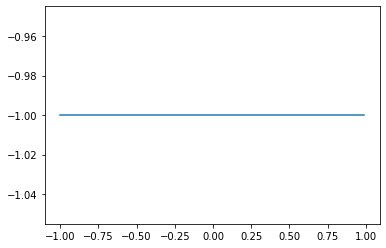

In [192]:
plt.plot(betas, critic(np.expand_dims(betas,axis=1)).numpy().flatten())